Código elaborado por Claudiomar para fins didáticos em 01/08/2025

# Detecção de Outliers (População e IDHM) com IQR + Tratamento de NA

## O que este notebook faz
1. **Upload** de uma planilha Excel (`.xlsx`) com dados municipais/estaduais.  
2. **Checa valores ausentes (NA)** e depois toma uma decisão de como atuar
3. **Calcula quartis (Q1, Q3)**, **IQR** e os **limites de outlier** pela regra de Tukey Q1-1,5*IQR e Q3+1,5*IQR
4. Plota **boxplots** e **histogramas** para visualização (um gráfico por figura).

O que é IQR?

IQR vem de Interquartile Range, ou Intervalo Interquartil em português.

É a diferença entre o 3º quartil (Q3) e o 1º quartil (Q1):

IQR=Q3−Q1

Q1 (1º quartil, ou percentil 25%): valor abaixo do qual estão 25% dos dados.

Q3 (3º quartil, ou percentil 75%): valor abaixo do qual estão 75% dos dados.

👉 Em resumo: o IQR mede a faixa central onde está metade dos dados (entre 25% e 75%).


> **Observação didática:** Outlier = indicador prático de valor **muito distante** do centro da distribuição.  
> Não é “erro” por definição; a interpretação depende do **contexto** (ex.: capitais muito populosas são esperadas como “extremos”).

## O que é um Boxplot

O boxplot (ou diagrama de caixa) é um gráfico estatístico que resume a distribuição dos dados de forma visual e compacta.
Ele mostra como os valores se espalham, onde está o meio da distribuição e quais pontos estão muito afastados (os possíveis outliers).

Um boxplot é composto por:

Caixa (box): vai do primeiro quartil (Q1) ao terceiro quartil (Q3), ou seja, contém os 50% centrais dos dados.

Linha dentro da caixa: representa a mediana (Q2), o ponto central da distribuição.

“Bigodes” (whiskers): se estendem até os limites calculados com base no IQR — geralmente Q1 − 1,5×IQR e Q3 + 1,5×IQR.

Pontos isolados: valores fora desses limites, considerados outliers.

💡 Interpretação didática:

Se a caixa está simétrica, os dados são equilibrados.

Se está puxada para um lado, há assimetria.

Pontos fora dos bigodes indicam valores atípicos que merecem investigação.


In [1]:
# ===== 1) Upload e leitura do arquivo Excel =====
import unicodedata
import pandas as pd               # biblioteca para manipulação de dados
from google.colab import files    # módulo do Colab para upload de arquivos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Abrir janela para o usuário selecionar o arquivo .xlsx
uploaded = files.upload()

# 2. Pegar o nome do arquivo enviado (chave do dicionário "uploaded")
caminho = list(uploaded.keys())[0]

# 3. Ler o Excel para um DataFrame do pandas
df = pd.read_excel(caminho)

# 4. Mostra sempre com ponto decimal e sem separador de milhar
pd.options.display.float_format = '{:.2f}'.format

# 5. Mostrar as 5 primeiras linhas para inspecionar
df.head()


Saving planilha bruta.xlsx to planilha bruta.xlsx


,codigo_ibge_6,municipio,uf,cod_uf,UF extenso,Região,Capital?,População 2022,idhm_2010
0,110001,Alta Floresta D'Oeste,RO,11,Rondônia,Norte,n,21495,0.64
1,110002,Ariquemes,RO,11,Rondônia,Norte,n,96833,0.70
2,110003,Cabixi,RO,11,Rondônia,Norte,n,5363,0.65
3,110004,Cacoal,RO,11,Rondônia,Norte,n,86895,0.72
4,110005,Cerejeiras,RO,11,Rondônia,Norte,n,15890,0.69


In [2]:
# ===== 2) Checando os NAs e mandando um describe
df.describe()


,codigo_ibge_6,cod_uf,População 2022,idhm_2010
count,5570.00,5570.00,5570.00,5564.00
mean,325358.63,32.38,36456.47,0.66
std,98491.03,9.83,206517.02,0.07
min,110001.00,11.00,833.00,0.42
25%,251212.50,25.00,5228.00,0.60
50%,314627.50,31.00,11065.00,0.67
75%,411918.75,41.00,24427.25,0.72
max,530010.00,53.00,11451245.00,0.86


In [3]:
#Vou renomear as colunas para ficar mais fácil de ler

# Renomear colunas
df = df.rename(columns={
    'População 2022': 'col_pop',
    'idhm_2010': 'col_idhm'
})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   codigo_ibge_6  5570 non-null   int64  
 1   municipio      5570 non-null   object 
 2   uf             5570 non-null   object 
 3   cod_uf         5570 non-null   int64  
 4   UF extenso     5570 non-null   object 
 5   Região         5570 non-null   object 
 6   Capital?       5570 non-null   object 
 7   col_pop        5570 non-null   int64  
 8   col_idhm       5564 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 391.8+ KB


In [5]:
# Como são apenas 6 NAs na coluna de IDHM, tomei a decisão de preenchê-los com a média do IDHM

# ===== 3) Preencher com a MÉDIA os NA =====

# Calcular médias
media_idhm = df["col_idhm"].mean(skipna=True)

# Preencher NA com a média
df["col_idhm"] = df["col_idhm"].fillna(media_idhm)

print(f"Média usada em idhm     : {media_idhm:.4f}")


Média usada em idhm     : 0.6591676851186197


In [6]:
#Checando se deu tudo certo
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   codigo_ibge_6  5570 non-null   int64  
 1   municipio      5570 non-null   object 
 2   uf             5570 non-null   object 
 3   cod_uf         5570 non-null   int64  
 4   UF extenso     5570 non-null   object 
 5   Região         5570 non-null   object 
 6   Capital?       5570 non-null   object 
 7   col_pop        5570 non-null   int64  
 8   col_idhm       5570 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 391.8+ KB


In [7]:
# ===== OUTLIERS EM POPULAÇÃO (col_pop) =====

# 1) selecionar a coluna (já sem NA porque você imputou; se ainda tiver NA, uso dropna. Vou deixar o dropna por via das dúvidas)
x_pop = df["col_pop"].astype(float).dropna()    # garante numérico e remove faltantes, só por segurança

# 2) quartis e IQR
Q1_pop = np.percentile(x_pop, 25)               # 1º quartil (25%)
Q3_pop = np.percentile(x_pop, 75)               # 3º quartil (75%)
IQR_pop = Q3_pop - Q1_pop                       # intervalo interquartil

# 3) limites de Tukey (1,5 * IQR)
lim_inf_pop = Q1_pop - 1.5 * IQR_pop
lim_sup_pop = Q3_pop + 1.5 * IQR_pop

# 4) Mostrar limites
print(f"Limite inferior (população): {lim_inf_pop:.2f}")
print(f"Limite superior (população): {lim_sup_pop:.2f}")

# 5) Contar quantos valores estão acima e abaixo dos limites
acima = (df["col_pop"] > lim_sup_pop).sum()     # quantos acima
abaixo = (df["col_pop"] < lim_inf_pop).sum()    # quantos abaixo

print(f"Valores acima do limite superior: {acima}")
print(f"Valores abaixo do limite inferior: {abaixo}")



Limite inferior (população): -23570.88
Limite superior (população): 53226.12
Valores acima do limite superior: 605
Valores abaixo do limite inferior: 0


In [10]:
# ===== OUTLIERS EM IDHM (col_idhm) =====

# 1) selecionar a coluna (já sem NA porque você imputou; se ainda tiver NA, uso dropna)
x_idhm = df["col_idhm"].astype(float).dropna()    # garante numérico e remove faltantes

# 2) quartis e IQR
Q1_idhm = np.percentile(x_idhm, 25)               # 1º quartil (25%)
Q3_idhm = np.percentile(x_idhm, 75)               # 3º quartil (75%)
IQR_idhm = Q3_idhm - Q1_idhm                       # intervalo interquartil

# 3) limites de Tukey (1,5 * IQR)
lim_inf_idhm = Q1_idhm - 1.5 * IQR_idhm
lim_sup_idhm = Q3_idhm + 1.5 * IQR_idhm

# 4) Mostrar limites
print(f"Limite inferior (IDHM): {lim_inf_idhm:.3f}")
print(f"Limite superior (IDHM): {lim_sup_idhm:.3f}")

# 5) Contar quantos valores estão acima e abaixo dos limites
acima_idhm = (df["col_idhm"] > lim_sup_idhm).sum()     # quantos acima
abaixo_idhm = (df["col_idhm"] < lim_inf_idhm).sum()    # quantos abaixo

print(f"Valores acima do limite superior: {acima_idhm}")
print(f"Valores abaixo do limite inferior: {abaixo_idhm}")


Limite inferior (IDHM): 0.420
Limite superior (IDHM): 0.896
Valores acima do limite superior: 0
Valores abaixo do limite inferior: 1


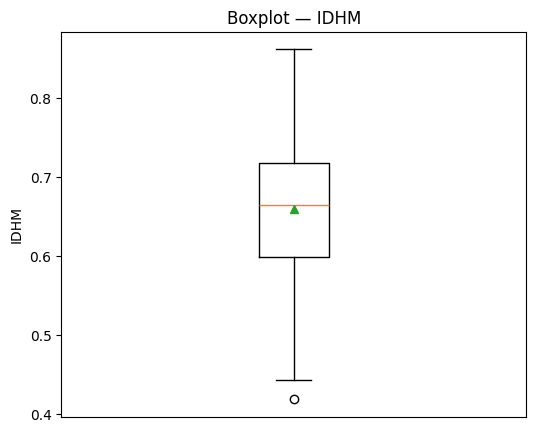

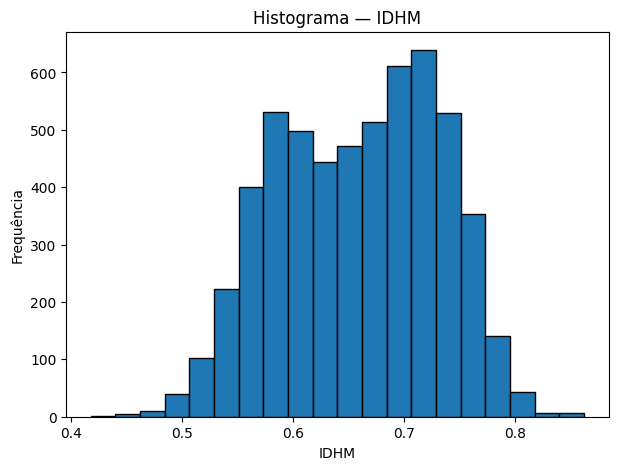

In [11]:
# ===== 5) Boxplots e histogramas =====
# Criar uma nova figura para o boxplot (6x5 polegadas)
plt.figure(figsize=(6,5))

# Fazer o boxplot da coluna col_idhm
# - vert=True -> gráfico na vertical
# - showmeans=True -> mostra a média (triângulo verde)
plt.boxplot(df["col_idhm"], vert=True, showmeans=True)

# Título e rótulo do eixo Y
plt.title('Boxplot — IDHM')
plt.ylabel('IDHM')
plt.xticks([])   # remove ticks/labels do eixo X

# Exibir o gráfico
plt.show()

# Criar uma nova figura para o histograma (7x5 polegadas)
plt.figure(figsize=(7,5))

# Fazer o histograma da coluna col_idhm
# - bins=20 -> divide os valores em 20 intervalos (barras)
# - edgecolor='black' -> contorno preto nas barras
plt.hist(df["col_idhm"], bins=20, edgecolor='black')

# Título e rótulos dos eixos
plt.title('Histograma — IDHM')
plt.xlabel('IDHM')           # eixo X = valores do IDHM
plt.ylabel('Frequência')     # eixo Y = quantas observações em cada faixa

# Exibir o gráfico
plt.show()



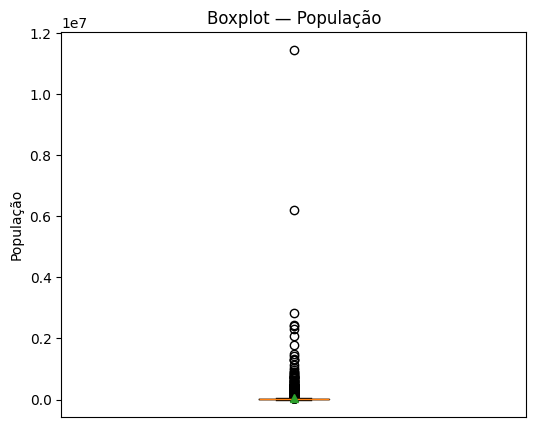

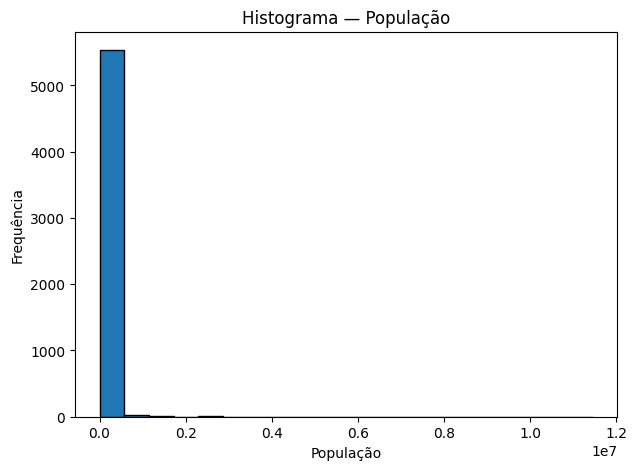

In [12]:
plt.figure(figsize=(6,5))
plt.boxplot(df["col_pop"], vert=True, showmeans=True)
plt.title('Boxplot — População')
plt.ylabel('População')
plt.xticks([])
plt.show()

plt.figure(figsize=(7,5))
plt.hist(df["col_pop"], bins=20, edgecolor='black')
plt.title('Histograma — População')
plt.xlabel('População')
plt.ylabel('Frequência')
plt.show()

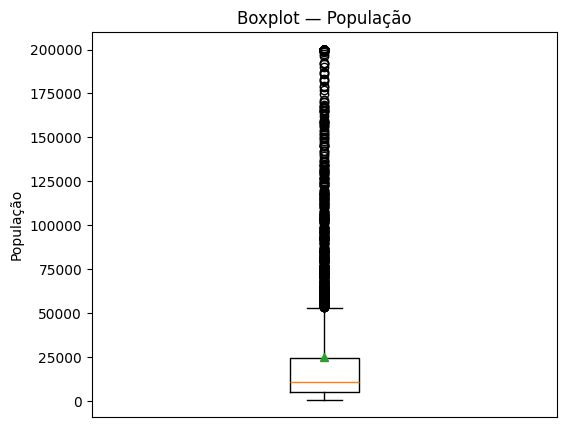

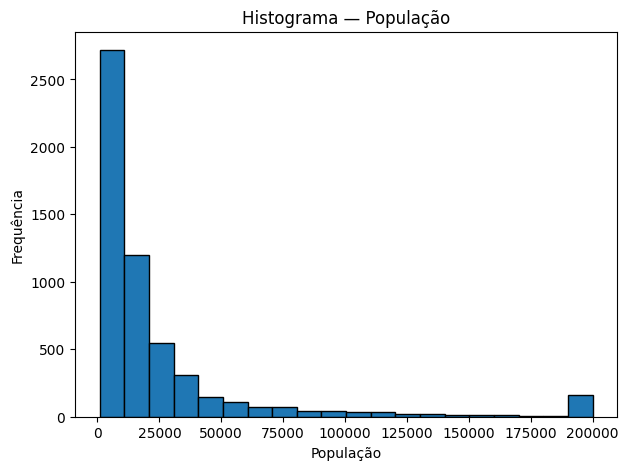

In [13]:
#Então vamos arrumar os nossos dados de população retirando os outliers.
#Tudo bem que nossos outliers começam em 53226 habitantes, mas vamos dar a mesma pontuação para todas cidades acima de 200.000

# Substituir valores da coluna 'col_pop' que sejam maiores que 200.000 por 200.000
# A lógica é:
# - df["col_pop"] > 200000 → cria uma condição booleana (True/False) para cada linha
# .loc[] é usado para localizar e alterar partes específicas do DataFrame.
# A estrutura é df.loc[linhas, colunas].
# No caso abaixo:
# 1) df["col_pop"] > 200000 cria uma série booleana (True/False) indicando quais linhas atendem à condição.
# 2) df.loc[condição, "col_pop"] seleciona apenas as linhas da coluna 'col_pop' onde a condição é True.
# 3) = 200000 substitui o valor dessas posições por 200.000.
# Em resumo: substitui todos os valores acima de 200.000 na coluna 'col_pop' por 200.000.
df.loc[df["col_pop"] > 200000, "col_pop"] = 200000

plt.figure(figsize=(6,5))
plt.boxplot(df["col_pop"], vert=True, showmeans=True)
plt.title('Boxplot — População')
plt.ylabel('População')
plt.xticks([])
plt.show()

plt.figure(figsize=(7,5))
plt.hist(df["col_pop"], bins=20, edgecolor='black')
plt.title('Histograma — População')
plt.xlabel('População')
plt.ylabel('Frequência')
plt.show()

# O que é Normalização?

Normalização é um jeito de **colocar diferentes variáveis na mesma escala**, sem mudar a ordem ou a proporção entre elas.  
Isso é útil porque cada coluna do nosso banco pode estar em uma escala diferente:  
- População pode ir de **milhares até milhões** de habitantes.  
- IDHM vai de **0 a 1**.  

Se deixarmos assim, a coluna população "domina" qualquer comparação, só porque os números são muito maiores.  
A normalização resolve isso.

---

## Exemplo simples

Imagine duas cidades:
- Cidade A: População = 1.000  
- Cidade B: População = 10.000  

Se o mínimo for 1.000 e o máximo for 10.000, depois da normalização:  
- Cidade A → 0 (porque é a menor)  
- Cidade B → 1 (porque é a maior)  

E uma cidade com 5.500 habitantes ficaria **no meio do caminho** → 0,5.  

Assim todos os valores ficam **entre 0 e 1**, facilitando a comparação.

---

## No nosso caso

A **menor população** recebe 0 e a **maior** recebe 1.

Depois invertemos. O **maior IDHM** recebe 0 e o **menor** recebe 1.  

  Esse truque é útil quando queremos que “pior situação” = valor mais alto e “melhor situação” = valor mais baixo.

---

📌 Em resumo:  
- Normalização coloca tudo na mesma escala (0 a 1).  
- Facilita comparações e combinações de indicadores.  
- Dependendo do objetivo, podemos inverter a lógica (0 = melhor, 1 = pior).

In [14]:
# ===== NORMALIZAÇÃO (fim do fluxo) =====
# Objetivo:
# - pop_norm      : menor população -> 0 ; maior população -> 1  (min-max padrão)
# - idhm_norm_inv : maior IDHM -> 0 ; menor IDHM -> 1            (min-max invertido)

# --- 1) Preparar mínimos e máximos ---
pop_min = df["col_pop"].min()           # menor população
pop_max = df["col_pop"].max()           # maior população
idhm_min = df["col_idhm"].min()         # menor IDHM
idhm_max = df["col_idhm"].max()         # maior IDHM

#Fazendo os ranges
pop_range  = pop_max  - pop_min
idhm_range = idhm_max - idhm_min

# --- 2) Criar colunas normalizadas ---
# População: (x - min) / (max - min)
df["pop_norm"] = (df["col_pop"] - pop_min) / pop_range

# IDHM invertido: (max - x) / (max - min)
df["idhm_norm_inv"] = (idhm_max - df["col_idhm"]) / idhm_range

# Espiar as novas colunas
df[["col_pop", "pop_norm", "col_idhm", "idhm_norm_inv"]].head()


,col_pop,pop_norm,col_idhm,idhm_norm_inv
0,21495,0.10,0.64,0.50
1,96833,0.48,0.70,0.36
2,5363,0.02,0.65,0.48
3,86895,0.43,0.72,0.32
4,15890,0.08,0.69,0.38


In [15]:
# ➕ Criar uma nova coluna 'nota_ranking'
# Ela será a soma das duas colunas: 'pop_norm' + 'idhm_norm_inv'
df["nota_ranking"] = df["pop_norm"] + df["idhm_norm_inv"]

# 📊 Ordenar o DataFrame de acordo com 'nota_ranking'
# O argumento ascending=False coloca os maiores valores primeiro
df = df.sort_values(by="nota_ranking", ascending=False)

# ✏️ Renomear as colunas para nomes mais descritivos
df = df.rename(columns={
    "idhm_norm_inv": "Nota normalizada de IDHM",
    "pop_norm": "Nota normalizada de população"
})

# 👀 Visualizar as primeiras linhas para conferir
df.head()


,codigo_ibge_6,municipio,uf,cod_uf,UF extenso,Região,Capital?,col_pop,col_idhm,Nota normalizada de população,Nota normalizada de IDHM,nota_ranking
1650,270030,Arapiraca,AL,27,Alagoas,Nordeste,n,200000,0.65,1.00,0.48,1.48
216,150420,Marabá,PA,15,Pará,Norte,n,200000,0.67,1.00,0.44,1.44
1507,260410,Caruaru,PE,26,Pernambuco,Nordeste,n,200000,0.68,1.00,0.42,1.42
2042,291840,Juazeiro,BA,29,Bahia,Nordeste,n,200000,0.68,1.00,0.42,1.42
2237,293330,Vitória Da Conquista,BA,29,Bahia,Nordeste,n,200000,0.68,1.00,0.41,1.41


In [16]:
df.describe()

,codigo_ibge_6,cod_uf,col_pop,col_idhm,Nota normalizada de população,Nota normalizada de IDHM,nota_ranking
count,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00
mean,325358.63,32.38,25183.58,0.66,0.12,0.46,0.58
std,98491.03,9.83,39693.41,0.07,0.20,0.16,0.22
min,110001.00,11.00,833.00,0.42,0.00,0.00,0.03
25%,251212.50,25.00,5228.00,0.60,0.02,0.32,0.42
50%,314627.50,31.00,11065.00,0.67,0.05,0.44,0.55
75%,411918.75,41.00,24427.25,0.72,0.12,0.59,0.70
max,530010.00,53.00,200000.00,0.86,1.00,1.00,1.48


In [17]:
#Vamos fazer uma estatística descritiva nas primeiras 500 cidades

# 🔝 Selecionar apenas as 500 primeiras linhas (já estão ordenadas pela nota_ranking)
top_500 = df.head(500)

#Fazendo a estatística descritiva


print(top_500["uf"].value_counts())
print("\n")
print(top_500["Região"].value_counts())
top_500.describe()

uf
PA    63
SP    61
MA    50
BA    44
PE    35
RJ    28
AM    27
MG    25
CE    24
PR    20
AL    20
RS    17
GO    11
SC    11
PI    11
SE     9
ES     9
PB     6
RN     6
AC     6
MT     4
RR     3
MS     3
AP     2
RO     2
TO     2
DF     1
Name: count, dtype: int64


Região
Nordeste        205
Sudeste         123
Norte           105
Sul              48
Centro-Oeste     19
Name: count, dtype: int64


,codigo_ibge_6,cod_uf,col_pop,col_idhm,Nota normalizada de população,Nota normalizada de IDHM,nota_ranking
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,275732.69,27.46,116560.76,0.66,0.58,0.46,1.05
std,98114.40,9.76,70451.29,0.10,0.35,0.24,0.17
min,110012.00,11.00,5496.00,0.42,0.02,0.03,0.85
25%,210396.00,21.00,47971.25,0.56,0.24,0.25,0.89
50%,270700.00,27.00,117025.50,0.67,0.58,0.42,0.99
75%,350342.50,35.00,200000.00,0.75,1.00,0.69,1.19
max,530010.00,53.00,200000.00,0.85,1.00,1.00,1.48


In [21]:
# ===== SALVAR E FAZER DOWNLOAD =====
# Salva o DataFrame com as novas colunas em CSV e faz o download no Colab.

# 1) Salvar CSV localmente
arquivo_saida = "dados_normalizados.csv"
df.to_csv(arquivo_saida, index=False,encoding="utf-8-sig")

# 2) Fazer download (Google Colab)
from google.colab import files
files.download(arquivo_saida)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>